# <center>Freesound General-Purpose Audio Tagging Challenge</center>

In [179]:
# Change this to True to replicate the result
COMPLETE_RUN = True

<a id="loading_data"></a>
### Loading data

In [2]:
import numpy as np
np.random.seed(1001)

import os
import shutil

#import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#from tqdm import tqdm_notebook
#from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

%matplotlib inline
matplotlib.style.use('ggplot')

import keras
print('keras version:',keras.__version__)
import tensorflow as tf
print('tf version:',tf.__version__)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)


Using TensorFlow backend.


keras version: 2.0.8
tf version: 1.1.0


In [181]:
train = pd.read_csv("../input/freesound-audio-tagging/train.csv")
##train = pd.read_csv("../input/freesound-audio-tagging/semi_train.csv")
test = pd.read_csv("../input/freesound-audio-tagging/sample_submission.csv")

In [182]:
train.head()

,fname,label,manually_verified,label_idx,semi
0,00044347.wav,Hi-hat,0,0,1.0
1,001ca53d.wav,Saxophone,1,1,1.0
2,002d256b.wav,Trumpet,0,2,0.0
3,0033e230.wav,Glockenspiel,1,3,1.0
4,00353774.wav,Cello,1,4,1.0


In [183]:
print("Number of training examples=", train.shape[0], "  Number of classes=", len(train.label.unique()))

Number of training examples= 9473   Number of classes= 41


In [184]:
print(train.label.unique())

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


<a id="distribution"></a>
### Distribution of Categories

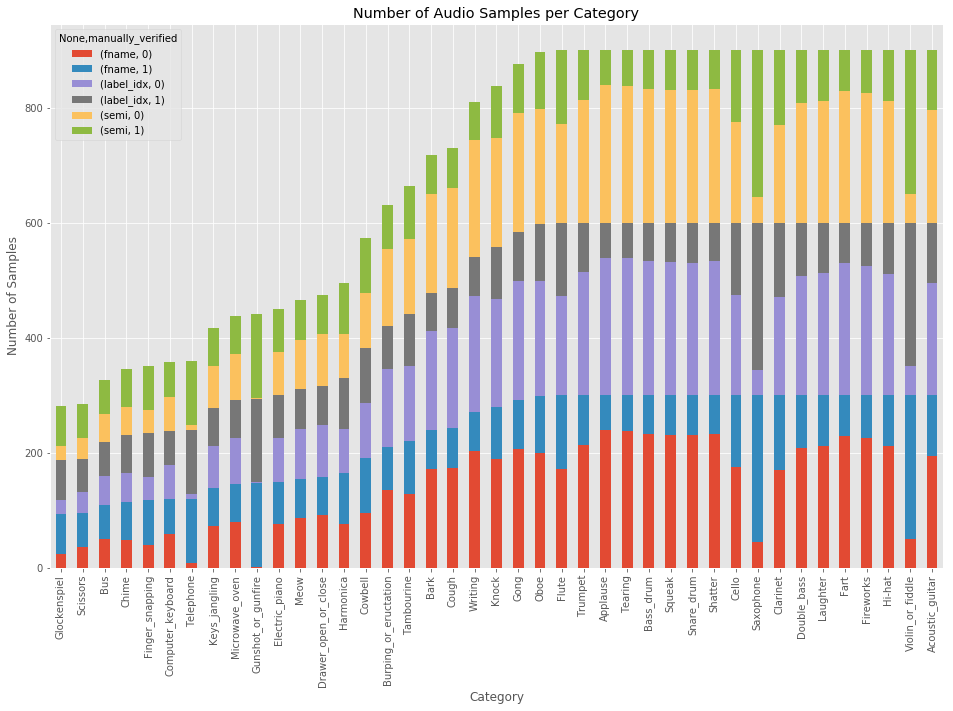

In [185]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [186]:
print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  94
Maximum samples per category =  300


We observe that:
1. The number of audio samples per category is **non-nform**. The minimum number of audio samples in a category is `94` while the maximum is `300`
2. Also, the proportion of `maually_verified` labels per category is non-uniform.
<a id="audio_files"></a>
### Reading Audio Files

The audios are [Pulse-code modulated](https://en.wikipedia.org/wiki/Audio_bit_depth) with a [bit depth](https://en.wikipedia.org/wiki/Audio_bit_depth) of 16 and a [sampling rate](https://en.wikipedia.org/wiki/Sampling_%28signal_processing%29) of 44.1 kHz

![16-bit PCM](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Pcm.svg/500px-Pcm.svg.png)

* **Bit-depth = 16**: The amplitude of each sample in the audio is one of 2^16 (=65536) possible values. 
* **Samplig rate = 44.1 kHz**: Each second in the audio consists of 44100 samples. So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100\*3.2 = 141120 values.

Let's listen to an audio file in our dataset and load it to a numpy array

<a id="1d_model_building"></a>
## <center>2. Building a Model using Raw Wave</center>
We will build two models:
1. The first model will take the raw audio (1D array) as input and the primary operation will be Conv1D
2. The second model will take the MFCCs as input. (We will explain MFCC later)

<a id="1d_discription"></a>
### Keras Model using raw wave

Our model has the architecture as follows:
![raw](https://raw.githubusercontent.com/zaffnet/images/master/images/raw_model.jpg)

**Important:**
Due to the time limit on Kaggle Kernels, it is not possible to perform 10-fold training of a large model. I have trained the model locally and uploaded its output files as a dataset. If you wish to train the bigger model, change `COMPLETE_RUN = True` at the beginning of the kernel.

#### Some sssential imports

In [187]:
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

<a id="configuration"></a>
#### Configuration

The Configuration object stores those learning parameters that are shared between data generators, models, and training functions. Anything that is `global` as far as the training is concerned can become the part of Configuration object.

In [188]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

<a id="data_generator"></a>
#### DataGenerator Class

The DataGenerator class inherits from **`keras.utils.Sequence`** . It is useful for preprocessing and feeding the data to a Keras model. 
* Once initialized with a batch_size, it computes the number of batches in an epoch. The **`__len__`** method tells Keras how many batches to draw in each epoch. 
* The **`__getitem__`** method takes an index (which is the batch number) and returns a batch of the data (both X and y) after calculating the offset. During test time, only `X` is returned.
* If we want to perform some action after each epoch (like shuffle the data, or increase the proportion of augmented data), we can use the **`on_epoch_end`** method.

Note:
**`Sequence`** are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.

In [189]:
class DataGenerator(Sequence):
    def __init__(self, config, data_dir, list_IDs, labels=None, 
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID
            
            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                        res_type='kaiser_fast')

            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                
            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                                   n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

<a id="1d_normalization"></a>
#### Normalization

Normalization is a crucial preprocessing step. The simplest method is rescaling the range of features to scale the range in [0, 1]. 

In [3]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    max = max_data
    if max < -min_data: 
        max = -min_data
    data = data/(max+1e-6)
    return data * 0.5

* The dummy model is just for debugging purpose.
* Our 1D Conv model is fairly deep and is trained using Adam Optimizer with a learning rate of 0.0001

In [191]:
def get_1d_dummy_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = GlobalMaxPool1D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

def get_1d_conv_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)
    x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
    x = MaxPool1D(16)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation=relu)(x)
    x = Dense(128, activation=relu)(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

<a id="1d_training"></a>
#### Training 1D Conv

It is important to convert raw labels to integer indices

In [192]:
LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: label_idx[x])
if not COMPLETE_RUN:
    train = train[:2000]
    test = test[:2000]

config = Config(sampling_rate=16000, audio_duration=2, n_folds=10, learning_rate=0.001, max_epochs = 30)
if not COMPLETE_RUN:
    config = Config(sampling_rate=100, audio_duration=1, n_folds=2, max_epochs=1)

Here is the code for 10-fold training:
* We use **`from sklearn.cross_validation.StratifiedKFold`** for splitting the trainig data into 10 folds.
* We use some Keras callbacks to monitor the training.
    * **`ModelCheckpoint`** saves the best weight of our model (using validation data). We use this weight to make test predictions.
    * **`EarlyStopping`** stops the training once validation loss ceases to decrease
    * **`TensorBoard`** helps us visualize training and validation loss and accuracy.
* We fit the model using **`DataGenerator`** for training and validation splits. 
* We get both training and test predictions and save them as .npy format. We also generate a submission file. For 10-fold CV, the number of prediction files should be 10. We will ensemble these predictions later.

#```python
PREDICTION_FOLDER = "predictions_1d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

#skf = StratifiedKFold(train.label_idx, n_folds=config.n_folds)
skf = StratifiedKFold(n_splits=config.n_folds).split(train, train.label_idx)

for i, (train_split, val_split) in enumerate(skf):
    train_set = train.iloc[train_split]
    val_set = train.iloc[val_split]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%d'%i, write_graph=True)

    callbacks_list = [checkpoint, early, tb]
    print("Fold: ", i)
    print("#"*50)
    if COMPLETE_RUN:
        model = get_1d_conv_model(config)
    else:
        model = get_1d_dummy_model(config)

    train_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', train_set.index, 
                                    train_set.label_idx, batch_size=64,
                                    preprocessing_fn=audio_norm)
    val_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', val_set.index, 
                                  val_set.label_idx, batch_size=64,
                                  preprocessing_fn=audio_norm)
    
    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                                  epochs=config.max_epochs, use_multiprocessing=True, workers=6, max_queue_size=20)
    
    model.load_weights('best_%d.h5'%i)
    
    # Save train predictions
    train_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', train.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(train_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)
    
    # Save test predictions
    test_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_test/', test.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(test_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)
    
    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)
#    ```

<a id="1d_ensembling"></a>
#### Ensembling 1D Conv Predictions
Now that we have trained our model, it is time average the predictions of 10-folds. We will try Geometric Mean averaging and see what will be our Public LB score.

pred_list = []
for i in range(10):
    pred_list.append(np.load(PREDICTION_FOLDER+"/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("1d_conv_ensembled_submission.csv", index=False)

<a id="intro_mfcc"></a>
## <center> 3. Introuction to MFCC

As we have seen in the previous section, our Deep Learning models are powerful enough to classify sounds from the raw audio. We do not require any complex feature engineering. But before the Deep Learning era, people developed techniques to extract features from audio signals. It turns out that these techniques are still useful. One such technique is computing the MFCC (Mel Frquency Cepstral Coefficients) from the raw audio. Before we jump to MFCC, let's talk about extracting features from the sound.

If we just want to classify some sound, we should build features that are **speaker independent**. Any feature that only gives information about the speaker (like the pitch of their voice) will not be helpful for classification. In other words, we should extract features that depend on the "content" of the audio rather than the nature of the speaker. Also, a good feature extraction technique should mimic the human speech perception. We don't hear loudness on a linear scale. If we want to double the perceived loudness of a sound, we have to put 8 times as much energy into it. Instead of a linear scale, our perception system uses a log scale. 

Taking these things into account, Davis and Mermelstein came up with MFCC in the 1980's. MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics. The underlying mathematics is quite complicated and we will skip that. For those interested, here is the [detailed explanation](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

![http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png](http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png)

<a id="librosa_mfcc"></a>
#### Generating MFCC using Librosa
The library librosa has a function to calculate MFCC. Let's compute the MFCC of an audio file and visualize it.

In [193]:
import librosa
SAMPLE_RATE = 44100
fname = '../input/freesound-audio-tagging/audio_train/' + '00044347.wav'   # Hi-hat
wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
wav = wav[:2*44100]

In [194]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=40)
mfcc.shape

(40, 173)

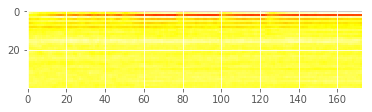

In [195]:
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

<a id="2d_model_building"></a>
## <center>4. Building a Model using MFCC

We will build now build a 2D Convolutional model using MFCC. 

In [196]:
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K

In [197]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

<a id="2d_data"></a>
### Preparing data

In [198]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=5, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=40)
if not COMPLETE_RUN:
    config = Config(sampling_rate=44100, audio_duration=2, n_folds=2, 
                    max_epochs=1, use_mfcc=True, n_mfcc=40)

In [199]:
def prepare_data(df, config, data_dir):
    
    
    
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in enumerate(df.index):
        print(fname)
        file_path = data_dir + fname
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

In [200]:
verified_only = False
semi_only = False
#```python
if(verified_only):
    vf = train["manually_verified"] == 1
    nonvf = train["manually_verified"] == 0
    Train = train[vf]
    train_nonvf = train[nonvf]
elif(semi_only):
    vf = train["semi"] == 1
    nonvf = train["semi"] == 0
    Train = train[vf]
    train_nonvf = train[nonvf]
else:
    nonvf = train["semi"] == 0
    Train = train
    train_nonvf = train[nonvf]
X_train = prepare_data(Train, config, '../input/freesound-audio-tagging/audio_train/')
X_train_nonvf = prepare_data(train_nonvf, config, '../input/freesound-audio-tagging/audio_train/')
X_test = prepare_data(test, config, '../input/freesound-audio-tagging/audio_test/')
y_train = to_categorical(Train.label_idx, num_classes=config.n_classes)
#```

00044347.wav
001ca53d.wav
002d256b.wav
0033e230.wav
00353774.wav
003b91e8.wav
003da8e5.wav
0048fd00.wav
004ad66f.wav
0063ab88.wav
006f2f32.wav
0075d39c.wav
00780200.wav
0079d310.wav
0091fc7f.wav
0097160c.wav
00ad7068.wav
00c5808a.wav
00c82919.wav
00c934d7.wav
00c9e799.wav
00cb787c.wav
00ce569f.wav
00d1fe46.wav
00d3bba3.wav
00d40fa2.wav
00d9fa61.wav
00e2b4cd.wav
00f88dc5.wav
00fbb28b.wav
00fcbab2.wav
010aa387.wav
011a2185.wav
0120d246.wav
01235a12.wav
01257aad.wav
01302128.wav
013264d3.wav
013c3135.wav
01506d76.wav
015cf474.wav
0160d55e.wav
01638f61.wav
0172a2a5.wav
017ea24e.wav
01811e48.wav
0184c390.wav
018863f5.wav
018a10bb.wav
018b1df6.wav
018d1dc4.wav
0193042e.wav
01974c7c.wav
019aae9d.wav
019d2a2c.wav
01a36643.wav
01a39e95.wav
01a59a61.wav
01a59c11.wav
01a5dc85.wav
01b9f44a.wav
01c2f88b.wav
01d2475c.wav
01d4dafd.wav
01df7ada.wav
01e723f5.wav
01ec7a01.wav
01ee18fd.wav
01f2e70b.wav
01fc4661.wav
020eb9f6.wav
021f8009.wav
022092bc.wav
02267a1a.wav
02274ee8.wav
022a3507.wav
022cc908.wav

11e3ffde.wav
11e63946.wav
11e9db25.wav
11f33ae4.wav
11f7fc13.wav
11f8b3dd.wav
11fab0b0.wav
11fbd6c2.wav
120536d6.wav
1207a675.wav
12091a74.wav
120e0846.wav
121110b1.wav
12169b86.wav
121749b9.wav
12198b88.wav
121d766e.wav
1220471f.wav
122b0e88.wav
12323e04.wav
12371b67.wav
1238c3a4.wav
123d0d60.wav
124360b8.wav
124eadc9.wav
125194b0.wav
125e64b7.wav
125e6ccf.wav
1264b8c7.wav
129439fd.wav
129dc328.wav
12a38093.wav
12a650a4.wav
12cb4097.wav
12d3cdd8.wav
12d43904.wav
12d4ec7c.wav
12e4c120.wav
12f72b79.wav
12fcf7a7.wav
1301b8e3.wav
13043bab.wav
1304d545.wav
1314cdad.wav
131b1516.wav
1329c048.wav
13314233.wav
134df575.wav
1356f987.wav
1365348d.wav
1373fdab.wav
1374fcda.wav
13798190.wav
13847ff3.wav
1387ba89.wav
13903b82.wav
1391883f.wav
1393c9e0.wav
1397ddc8.wav
139c42cb.wav
13ac472f.wav
13b2325b.wav
13ca1116.wav
13da16ae.wav
13db0700.wav
13e15a49.wav
13ee6c44.wav
13f08982.wav
140027c6.wav
1401c7ff.wav
14041f9a.wav
141291fc.wav
1415b8b9.wav
14225f23.wav
142cb2c4.wav
142dac40.wav
14303ca5.wav

22cc1654.wav
22cf5ded.wav
22d8346b.wav
22e1c02c.wav
22e814ee.wav
22e83dcb.wav
22f85886.wav
231b7c90.wav
23219d68.wav
23226fdd.wav
232cc8b2.wav
2336285e.wav
233fc9e5.wav
234a0656.wav
234f4672.wav
234f95ec.wav
23663788.wav
236648d4.wav
236b8093.wav
236cbab1.wav
23704fa9.wav
2371f627.wav
2372eeb4.wav
23786ab2.wav
237b9e2a.wav
237e1078.wav
2383be9f.wav
238b16a5.wav
238fb6b8.wav
23912d0e.wav
23925f36.wav
2392ad36.wav
2398cede.wav
23a1a82e.wav
23a3984c.wav
23b6d45c.wav
23b7d8f5.wav
23b8788a.wav
23bc06b9.wav
23c0de2c.wav
23c11bee.wav
23cb1f38.wav
23cdff07.wav
23e8ac90.wav
23ebf391.wav
23f38a7e.wav
23fb24e8.wav
240590c8.wav
2405de39.wav
24202032.wav
242113be.wav
24218e25.wav
2424ad60.wav
2439dedd.wav
244025d2.wav
24503135.wav
245a503a.wav
245e58ea.wav
2462c802.wav
246ad992.wav
246e8414.wav
24779e2d.wav
24791b50.wav
247ac56f.wav
2492a915.wav
249912b5.wav
2499fad5.wav
24a3c430.wav
24addbbc.wav
24b90fac.wav
24ba0ef2.wav
24bae325.wav
24cb1e29.wav
24dfdfa5.wav
24e1d9ad.wav
24e250f8.wav
24e8a804.wav

34bb94e8.wav
34c01286.wav
34c5db34.wav
34d0a285.wav
34d3e8bc.wav
34dacafb.wav
34dd9426.wav
34e04b95.wav
34e4d187.wav
34f10443.wav
35039ae1.wav
3505e582.wav
3518605b.wav
351d0b53.wav
35270d67.wav
35271da5.wav
352875e7.wav
353b359f.wav
354bd271.wav
354c7009.wav
354cabb9.wav
35571af7.wav
3564bae2.wav
35669b76.wav
356f6f26.wav
35717b0f.wav
35721b6a.wav
357a5b9a.wav
357f7e95.wav
358139e5.wav
35839982.wav
35844050.wav
3586bc2d.wav
3592e056.wav
35950597.wav
35a38d01.wav
35accc11.wav
35ad5cd8.wav
35bd35da.wav
35d75ab7.wav
35d7ac24.wav
35e0b4ea.wav
35e97db3.wav
35f05c5d.wav
35f0e452.wav
35f2639c.wav
35f589b8.wav
35f6b357.wav
35fb9b2e.wav
35fd6638.wav
3600d08e.wav
360174e1.wav
3601d225.wav
361230e1.wav
36177faa.wav
3618cb03.wav
3623e99e.wav
3626eabd.wav
36315bea.wav
36342286.wav
363c41b3.wav
3640c702.wav
3649d60c.wav
3650faee.wav
36514399.wav
365bee4a.wav
365d9809.wav
3662e614.wav
366664bb.wav
36698953.wav
366a5492.wav
3679b950.wav
367ad7b1.wav
367e990f.wav
368137a8.wav
368b7628.wav
368d4b71.wav

45539540.wav
45539bb8.wav
455aee34.wav
45665f2e.wav
456cc727.wav
458b1992.wav
458ea6cc.wav
4590ba37.wav
45910ae0.wav
45a8823e.wav
45a8d396.wav
45b9bc91.wav
45bf81f1.wav
45c077da.wav
45ce1b24.wav
45d405ca.wav
45d71502.wav
45da8553.wav
45de3233.wav
45e241c1.wav
45e5a952.wav
45e63fdd.wav
45e6e129.wav
45ea531e.wav
45f3e225.wav
4601c0f2.wav
46076458.wav
460d7b62.wav
461558c3.wav
4619c0dd.wav
461c6cd1.wav
4629e77b.wav
462b676f.wav
4636fd73.wav
464c651e.wav
465cf6eb.wav
46657625.wav
46670055.wav
466a45d5.wav
46732e56.wav
46768bc1.wav
46772c0d.wav
467953c6.wav
46798d97.wav
467ad774.wav
467c86b7.wav
468226fa.wav
468f9c4c.wav
469e4ebe.wav
46a95319.wav
46b52f97.wav
46b66e03.wav
46c0a7cd.wav
46d3877b.wav
46d7d98d.wav
46e13bac.wav
46fbedcf.wav
470e36b8.wav
470f4da3.wav
4713dac4.wav
4715ec32.wav
4715f79a.wav
4716c05b.wav
47178b5e.wav
471c8fa5.wav
471ecdc0.wav
471f4c1d.wav
472e6644.wav
472e7697.wav
47395931.wav
4740a159.wav
474d3f52.wav
476e192f.wav
476f3ba7.wav
47733230.wav
477622b6.wav
47797e57.wav

553245ef.wav
5543631a.wav
5554d95d.wav
5558f338.wav
5560b9c0.wav
557040c2.wav
557475a3.wav
55783841.wav
55822aae.wav
558a13e0.wav
55a17a88.wav
55a23759.wav
55aed1da.wav
55b2828b.wav
55b7b452.wav
55b7d572.wav
55c288a5.wav
55cb6a50.wav
55d52a69.wav
55d60bf0.wav
55dd4e7c.wav
55df0089.wav
5604d72a.wav
560506a1.wav
560977ac.wav
561d33d3.wav
56220972.wav
56238daa.wav
56239e18.wav
56271e97.wav
562d93f5.wav
562fed68.wav
5631d60b.wav
5638382e.wav
563f830b.wav
5644beb8.wav
564c018d.wav
564ebce0.wav
564f1a49.wav
5655bcc9.wav
565d4f5a.wav
565f3ee2.wav
5666db3a.wav
5668c2ab.wav
566f0926.wav
567ac6d1.wav
5683f1b4.wav
5689818f.wav
568f4336.wav
569ee690.wav
56a26f01.wav
56a59a85.wav
56aacb80.wav
56b18d22.wav
56bfa515.wav
56c1363d.wav
56c736b2.wav
56db9231.wav
56de1a6e.wav
56e0b337.wav
56e79c6f.wav
56ebef58.wav
56f6f5a1.wav
56fa2d08.wav
5700bda7.wav
57024106.wav
570742db.wav
5709ee5e.wav
571f47da.wav
572bb939.wav
57307037.wav
57419cc7.wav
5742568e.wav
574d304d.wav
5752e184.wav
575336af.wav
57540a22.wav

66b3d587.wav
66b65fff.wav
66b8f88f.wav
66bb1172.wav
66bcf27e.wav
66be15fd.wav
66bf4fa3.wav
66c39830.wav
66ccbc5f.wav
66dd3d3b.wav
66e0dd75.wav
66f8e692.wav
66fe50dc.wav
670093d9.wav
67013df6.wav
67052549.wav
67066eb2.wav
670a1d0b.wav
670b77c7.wav
670ef10d.wav
67186290.wav
673a623f.wav
673defaf.wav
674664a6.wav
674b6f0f.wav
674fed1f.wav
675e616f.wav
6760fd6d.wav
67822329.wav
67841fc1.wav
67909683.wav
67c69330.wav
67d86f23.wav
67e4e043.wav
67e80e0a.wav
67eceec7.wav
67ed3008.wav
67f5ced8.wav
67ffdc45.wav
68178f77.wav
681b996f.wav
6821edb0.wav
6823ee92.wav
6828f1a3.wav
682cd1a9.wav
6835397c.wav
684e4a9e.wav
68532fcb.wav
6855cd97.wav
685676c5.wav
68589f79.wav
685a6077.wav
685b5c1f.wav
686a78bf.wav
686bbe8b.wav
6876f41e.wav
68942258.wav
689aa181.wav
689ad798.wav
689af02b.wav
68a5d0d1.wav
68a93434.wav
68ae12e2.wav
68b11a4d.wav
68b4facc.wav
68b5bf43.wav
68bc0ce4.wav
68c2f93c.wav
68c57a43.wav
68ca0f14.wav
68d8b3fd.wav
68ddd963.wav
68e1a3e9.wav
68ef495a.wav
68f43bf1.wav
690556ea.wav
690a6466.wav

78e952a2.wav
78ea9935.wav
78f0c61d.wav
78f34b3a.wav
78f43145.wav
78f90b0f.wav
78fa599e.wav
790b0c13.wav
791648dc.wav
792e752d.wav
79340af7.wav
7936731d.wav
7938de7e.wav
7941de54.wav
7941ec33.wav
794a9e40.wav
794b500a.wav
794e4a17.wav
795e7c4d.wav
79613f7e.wav
796c25a1.wav
796e727c.wav
79753d0c.wav
7975c296.wav
798b33e8.wav
798d03b7.wav
798d6d5e.wav
799055b8.wav
7996c815.wav
79a0d2c4.wav
79a50c1d.wav
79a8dbcc.wav
79b29f52.wav
79b31a2e.wav
79b83450.wav
79bb1b55.wav
79bc77b2.wav
79be82bb.wav
79c2afb1.wav
79cbc8f6.wav
79cc9b98.wav
79cf0f4b.wav
79d44891.wav
79db26c2.wav
79e22357.wav
79e99e49.wav
79f04f95.wav
79faa0c4.wav
79fd94aa.wav
79fdfdb8.wav
7a002442.wav
7a0c3dfe.wav
7a18ea6f.wav
7a20c7f1.wav
7a23dada.wav
7a37c028.wav
7a392ab8.wav
7a397092.wav
7a3f81e2.wav
7a431157.wav
7a458eec.wav
7a4666c5.wav
7a47fd86.wav
7a515659.wav
7a59b5b0.wav
7a5a8e6a.wav
7a61b4f2.wav
7a66b759.wav
7a6d71fc.wav
7a6e15bd.wav
7a79b65a.wav
7a7a59fd.wav
7a7b777d.wav
7a80327b.wav
7a82bd12.wav
7a8580db.wav
7a871def.wav

89a645fe.wav
89adfd2e.wav
89affc19.wav
89b17560.wav
89c2111f.wav
89c5c01b.wav
89d12569.wav
89d16dbb.wav
89d4119c.wav
89da251b.wav
89e2578a.wav
89e543b0.wav
89f13bb9.wav
89f33989.wav
89f8b625.wav
8a05af88.wav
8a11b736.wav
8a13412a.wav
8a2f4e19.wav
8a364f26.wav
8a3e5147.wav
8a45aa41.wav
8a4d0d1e.wav
8a4fce15.wav
8a635ff8.wav
8a68f631.wav
8a6ad56f.wav
8a6c6627.wav
8a739529.wav
8a843f42.wav
8a853191.wav
8a8a9e60.wav
8a9c77de.wav
8aaada9f.wav
8aab3694.wav
8ac249cc.wav
8ad0ed99.wav
8ad14a86.wav
8ae50c6c.wav
8ae68e01.wav
8ae899e7.wav
8aeb76f4.wav
8af3c40f.wav
8b0408b1.wav
8b12ea14.wav
8b14e805.wav
8b28686b.wav
8b33f120.wav
8b3be47e.wav
8b466188.wav
8b49f457.wav
8b563f92.wav
8b5798fc.wav
8b5d8ca5.wav
8b5fbd09.wav
8b613dd2.wav
8b65c98b.wav
8b68eef8.wav
8b6a16de.wav
8b76e49d.wav
8b774232.wav
8b911fb3.wav
8ba4228c.wav
8bace939.wav
8bbd48e2.wav
8bc4df93.wav
8bc9a0b0.wav
8bd07e1d.wav
8bd43789.wav
8bd786e4.wav
8bd954b8.wav
8bdab359.wav
8bf04217.wav
8bf2660c.wav
8bf73516.wav
8bff2f37.wav
8c048e36.wav

9bedf2cf.wav
9beefea5.wav
9bf2f8d2.wav
9bf40e11.wav
9c0838c1.wav
9c0a8ebb.wav
9c0b64c2.wav
9c0cf859.wav
9c13c0f4.wav
9c25e6c0.wav
9c27892f.wav
9c2ba819.wav
9c33b001.wav
9c3579f4.wav
9c452692.wav
9c4a2e2c.wav
9c5309e1.wav
9c53c34c.wav
9c54eea1.wav
9c56788f.wav
9c673f64.wav
9c87b2a0.wav
9c917ad7.wav
9c91c331.wav
9c93f3f0.wav
9ca0bd7a.wav
9ca2691f.wav
9ca86e5e.wav
9cb64934.wav
9cb7a081.wav
9cc14c5f.wav
9cc1cf39.wav
9cc4b0d0.wav
9cd05a2b.wav
9cdbf719.wav
9cdfc973.wav
9ce1bcab.wav
9ced37af.wav
9cee0b0f.wav
9cf0cf51.wav
9cf3b168.wav
9cf87d5e.wav
9d0087cd.wav
9d03c79b.wav
9d04b931.wav
9d072bbc.wav
9d0ff24c.wav
9d265924.wav
9d26beb5.wav
9d308738.wav
9d357630.wav
9d362e9a.wav
9d365a21.wav
9d3927d8.wav
9d3bb566.wav
9d4e4025.wav
9d5784e8.wav
9d59a719.wav
9d5c11e3.wav
9d5cbd33.wav
9d674091.wav
9d85dc18.wav
9d868658.wav
9d89caeb.wav
9d9102a9.wav
9d9735fd.wav
9da365ac.wav
9da5d791.wav
9dac2618.wav
9dae7848.wav
9dae96ae.wav
9db39571.wav
9dba4c86.wav
9dd0141c.wav
9deab5af.wav
9dec6e79.wav
9df39dac.wav

adf374f7.wav
adfb7e0b.wav
ae046a29.wav
ae0820a8.wav
ae0d9801.wav
ae0ed31b.wav
ae12f941.wav
ae1d4a4b.wav
ae247229.wav
ae26f1af.wav
ae38fd74.wav
ae578781.wav
ae57e1ec.wav
ae58d0bb.wav
ae5b8b4b.wav
ae5c5c48.wav
ae5cabf7.wav
ae5fc8a0.wav
ae601b3b.wav
ae67b6b6.wav
ae6dc552.wav
ae7087c7.wav
ae733935.wav
ae76357b.wav
ae7d15cf.wav
ae7d1c37.wav
ae8d10a8.wav
ae8eee17.wav
ae927587.wav
ae9308c1.wav
ae9fb62c.wav
aea2ef3a.wav
aea3d36d.wav
aea6b912.wav
aeb5f4ce.wav
aeb76e9d.wav
aebf610f.wav
aecf8744.wav
aed229aa.wav
aed9d22f.wav
aeee87f3.wav
aeeeacfa.wav
aeeef40f.wav
aeef4dcd.wav
aef27ffa.wav
aef57ade.wav
aefa64ef.wav
aefc0858.wav
aefd8a46.wav
af16cacc.wav
af1b313a.wav
af1b323b.wav
af1b4a91.wav
af227d6f.wav
af24f6eb.wav
af26af82.wav
af2f888a.wav
af332bc7.wav
af37d60f.wav
af385e76.wav
af3ba889.wav
af3c04ec.wav
af4c4501.wav
af4d21ce.wav
af525d74.wav
af60b442.wav
af65e469.wav
af68a762.wav
af7d378f.wav
af8034f1.wav
af82c652.wav
af863e82.wav
af8b691d.wav
af8c4865.wav
af8f7b25.wav
afa00136.wav
afadb16e.wav

be93378b.wav
be93e48b.wav
be973667.wav
be990588.wav
bea51ca5.wav
bea68b34.wav
beb08c40.wav
beb0de1c.wav
beb6c84a.wav
bec7ea21.wav
bece203c.wav
bed02fc2.wav
bed04b14.wav
beddbf08.wav
bedf02c7.wav
bee83d50.wav
beeb29b2.wav
befa1789.wav
befdc449.wav
bf025873.wav
bf075487.wav
bf0d0b86.wav
bf0fb70c.wav
bf1103ee.wav
bf255693.wav
bf331561.wav
bf39476c.wav
bf3bd60f.wav
bf3cbeed.wav
bf45dce6.wav
bf47deb5.wav
bf4de14d.wav
bf5947a8.wav
bf5e79af.wav
bf644d3f.wav
bf68e89c.wav
bf7ac315.wav
bf7b5df3.wav
bf84f687.wav
bf87ccd1.wav
bf8bd663.wav
bf939cb3.wav
bf9c7ab9.wav
bf9dc054.wav
bfa765a5.wav
bfa912af.wav
bfad4e3c.wav
bfb17663.wav
bfbfa1d3.wav
bfc870a2.wav
bfd73e2b.wav
bfdc857c.wav
bfe47c66.wav
bfe8f24f.wav
bfe93942.wav
bfebf408.wav
bfeccbbd.wav
bfed2ab1.wav
bff620df.wav
bffc0cc1.wav
bffcf4a4.wav
bffd6b19.wav
c0031dcf.wav
c0041b0c.wav
c00b6fbb.wav
c010b3c1.wav
c015af58.wav
c015db25.wav
c017f3f7.wav
c01e53f9.wav
c01ea334.wav
c0236eea.wav
c02503c7.wav
c028d264.wav
c03a3077.wav
c03f458c.wav
c04afdc3.wav

ceca4273.wav
cee316e2.wav
ceebbf33.wav
cef7f23d.wav
cf048634.wav
cf09ca4f.wav
cf20556b.wav
cf2343c6.wav
cf242525.wav
cf2877fe.wav
cf3a73a6.wav
cf469143.wav
cf5073f3.wav
cf52251c.wav
cf59ffba.wav
cf6fd7a7.wav
cf73caf7.wav
cf79b314.wav
cf810e55.wav
cf8c5111.wav
cf9f9d32.wav
cfa61a1d.wav
cfa98877.wav
cfb2c5ee.wav
cfb4c434.wav
cfb55e4a.wav
cfb7c1ee.wav
cfb9c5fd.wav
cfbededb.wav
cfc76f15.wav
cfc91917.wav
cfccd445.wav
cfcf57f8.wav
cfd0f787.wav
cfd4461a.wav
cfd6085a.wav
cfdbf38b.wav
cfdfe861.wav
cfe317f8.wav
cfe45dd3.wav
cfecfc4e.wav
cff980e3.wav
cffa76ed.wav
d000e828.wav
d004048a.wav
d008a757.wav
d00f9207.wav
d011c434.wav
d0141870.wav
d0160c41.wav
d01af3cd.wav
d01afeb4.wav
d01cbcc8.wav
d0219079.wav
d0232e7e.wav
d02be75c.wav
d030ccde.wav
d033f680.wav
d035d92e.wav
d038c1e3.wav
d039d135.wav
d0434a11.wav
d04475f7.wav
d07b3486.wav
d0826760.wav
d085e7da.wav
d0863f10.wav
d09ef2c7.wav
d0a0fd54.wav
d0a7e96a.wav
d0a88003.wav
d0ac8e53.wav
d0c5c389.wav
d0d0249f.wav
d0d932ad.wav
d0db322f.wav
d0dd2ca3.wav

df73bad7.wav
df7593da.wav
df75d2e7.wav
df79d259.wav
df881a37.wav
df890004.wav
df8afeea.wav
df91fbcc.wav
df976153.wav
df98be15.wav
df9e6042.wav
dfb39975.wav
dfb42c74.wav
dfb8afae.wav
dfbeefb5.wav
dfbf40dd.wav
dfc4a855.wav
dfce618e.wav
dfd03330.wav
dfd3ad5c.wav
dfe13537.wav
dfe7423a.wav
dfed3be6.wav
dffc9217.wav
e0039925.wav
e00d4ff7.wav
e00ede63.wav
e01a1ca0.wav
e01f2d8b.wav
e022b7b0.wav
e030fb43.wav
e03693c5.wav
e0435db2.wav
e048451f.wav
e0681ca8.wav
e07214a4.wav
e072c537.wav
e0737e3b.wav
e076d62b.wav
e08535fa.wav
e0862ccc.wav
e087f227.wav
e08db496.wav
e092649c.wav
e093817a.wav
e095f5a6.wav
e0987b6a.wav
e0990da3.wav
e09acb52.wav
e09cc30b.wav
e09edb1f.wav
e0ba0ac2.wav
e0c71892.wav
e0c8cab1.wav
e0c92985.wav
e0d21768.wav
e0d32883.wav
e0ecd1a6.wav
e0f630f5.wav
e0fef04d.wav
e1002ae9.wav
e109a206.wav
e11fb127.wav
e128049a.wav
e128a8bd.wav
e12a53d6.wav
e14e0745.wav
e151f769.wav
e152333d.wav
e157f82f.wav
e1583260.wav
e158fd40.wav
e1708c89.wav
e186a347.wav
e18f928a.wav
e1957c8c.wav
e19b451d.wav

f0363605.wav
f040db67.wav
f0414445.wav
f042282c.wav
f044492f.wav
f0591dce.wav
f05dfc96.wav
f06c961d.wav
f0727eac.wav
f0734a33.wav
f074c2a8.wav
f0891606.wav
f08d2ce5.wav
f093caf9.wav
f09701aa.wav
f09f18fe.wav
f0a466a1.wav
f0a743c5.wav
f0b1afe7.wav
f0b40e7a.wav
f0bf7f04.wav
f0bfdfae.wav
f0c40412.wav
f0c79f5e.wav
f0d315bc.wav
f0d644d1.wav
f0dfe343.wav
f0e34f4c.wav
f0f17a5c.wav
f0f48b44.wav
f0f8d174.wav
f1033230.wav
f1062ecf.wav
f10a5f1c.wav
f10c7f27.wav
f10ddf95.wav
f11109de.wav
f1119913.wav
f114112a.wav
f133df4c.wav
f1352a21.wav
f1403f83.wav
f142df15.wav
f1562014.wav
f1573152.wav
f1691e35.wav
f1754aea.wav
f1839e9f.wav
f184970b.wav
f18df301.wav
f1923708.wav
f19f12a6.wav
f1a0a22a.wav
f1a14bdb.wav
f1b9def1.wav
f1c07799.wav
f1dcd7d5.wav
f1df9083.wav
f1e1bbc9.wav
f1e4a107.wav
f1ef90d8.wav
f1f2305d.wav
f1ff9d9f.wav
f2092017.wav
f20b8357.wav
f213ab3d.wav
f21dd004.wav
f22b1915.wav
f2310f0d.wav
f2331998.wav
f23cc73e.wav
f244e1e2.wav
f24ecfa8.wav
f24f8232.wav
f2505310.wav
f2517f57.wav
f256d891.wav

0733ce78.wav
0742098b.wav
074cc08b.wav
074e07a5.wav
0765b7d1.wav
07a177eb.wav
07af4f4d.wav
07c8c909.wav
07ed1d56.wav
08064f4a.wav
082321d2.wav
0832c151.wav
086dfaff.wav
08cf2d2b.wav
08dba5f4.wav
0939d783.wav
093bf325.wav
095836cb.wav
098a3205.wav
098c2232.wav
09986ba4.wav
09a732e6.wav
09a895f3.wav
09b51c66.wav
0a277f11.wav
0a2b4c80.wav
0a32271b.wav
0aa32376.wav
0aa7edd0.wav
0ac443ad.wav
0ac83c13.wav
0ade0819.wav
0afca134.wav
0afcf36b.wav
0b436682.wav
0b489adc.wav
0b4dc8fc.wav
0b5b6734.wav
0b6ac630.wav
0b6fba96.wav
0b74f0da.wav
0b7f8989.wav
0b9904c1.wav
0bb6b85a.wav
0be0fbaa.wav
0c28638b.wav
0c3cba8b.wav
0c3e92c7.wav
0cec67d2.wav
0d30af2b.wav
0d3d36f5.wav
0d649d1b.wav
0d694b51.wav
0d6bb959.wav
0dd326ca.wav
0dd54f1f.wav
0e32c361.wav
0e4372d4.wav
0e439e01.wav
0e51f1d0.wav
0e5c9ed0.wav
0f1dbff5.wav
0f274e7a.wav
0f444884.wav
0f70f92f.wav
0fa3ee45.wav
0fb0c2e1.wav
0ff6fdf5.wav
0ffff94f.wav
10099e50.wav
100f6b3f.wav
1032e684.wav
103dfb7c.wav
106f028c.wav
10783ffe.wav
108f96a6.wav
10961c54.wav

53b13ce5.wav
53b70883.wav
53b99f13.wav
53da29c9.wav
5448e59e.wav
5460a181.wav
546d1aa8.wav
54864b6d.wav
5495de48.wav
54a77272.wav
54a8e5b9.wav
54ab7672.wav
54beedf8.wav
54cfff7e.wav
5531a5e1.wav
5558f338.wav
5560b9c0.wav
56220972.wav
56239e18.wav
56271e97.wav
5655bcc9.wav
5683f1b4.wav
56a59a85.wav
56b18d22.wav
56c1363d.wav
56c736b2.wav
574d304d.wav
575d8f8f.wav
5775ce57.wav
57a3656e.wav
57aa8a3b.wav
57de0162.wav
5857ac4f.wav
5864d494.wav
589b7cbe.wav
58c581a3.wav
58cec63d.wav
58d4f832.wav
58e7e580.wav
59107829.wav
5966612f.wav
5967bec2.wav
59839dba.wav
59986c41.wav
59a80d41.wav
59ca9d6b.wav
5a7c8da8.wav
5a8e0ae7.wav
5abcd00b.wav
5afe0b38.wav
5b169f29.wav
5b46302b.wav
5b8e2fa4.wav
5b90d750.wav
5b9a8b5f.wav
5baff24a.wav
5c1932e9.wav
5c238ad9.wav
5c356407.wav
5c5dfa2e.wav
5c92ea4b.wav
5c967cf2.wav
5cc2be86.wav
5cddb6d3.wav
5d21633f.wav
5d36e4df.wav
5d4ee93d.wav
5d58aa13.wav
5d5c4b15.wav
5d5fecd0.wav
5d8e2712.wav
5dc55b0c.wav
5dee10ca.wav
5df7f1d0.wav
5e0b5087.wav
5e3b2fca.wav
5e626acd.wav

a8be1741.wav
a91f4173.wav
a940d6a8.wav
a94a1787.wav
a94d7cdc.wav
a95c016b.wav
a98a0999.wav
a9af525b.wav
a9bd898d.wav
a9be5059.wav
a9cd37c0.wav
a9e1b8a5.wav
a9f11d74.wav
a9f3c0c5.wav
aa8a72e3.wav
aa909ac6.wav
aaafd35a.wav
aac26506.wav
aac455cf.wav
aacefbf1.wav
aaf32210.wav
ab1279e3.wav
ab23edb1.wav
ab35fb1c.wav
aba09cf2.wav
abb62188.wav
abd3809f.wav
abd525ef.wav
abeb16ee.wav
abf52b5c.wav
ac00a026.wav
ac36d6ae.wav
ac42801e.wav
ac650d33.wav
ac98ea2b.wav
aca31840.wav
accdf31f.wav
ace78db8.wav
acf98333.wav
ad0436f7.wav
ad3ff995.wav
ad91fee3.wav
ad9a5db4.wav
adc9d9d8.wav
adfb7e0b.wav
ae0ed31b.wav
ae38fd74.wav
ae9308c1.wav
aea2ef3a.wav
aea3d36d.wav
aeb5f4ce.wav
aecf8744.wav
aeeef40f.wav
aefa64ef.wav
af82c652.wav
af8f7b25.wav
afbdea95.wav
b014444f.wav
b032262f.wav
b03d741d.wav
b04badcf.wav
b0549e4b.wav
b0a4f56d.wav
b0d08034.wav
b0d481d3.wav
b0e822b0.wav
b0f271a3.wav
b102d8e0.wav
b103d3b5.wav
b1128ed8.wav
b114fb4f.wav
b124ad3b.wav
b1437bd0.wav
b1567a16.wav
b1931977.wav
b1a843d3.wav
b1c0912f.wav

f6a3a18f.wav
f6a82a6c.wav
f71bd06e.wav
f7335046.wav
f739aa9a.wav
f755b7c8.wav
f75de4c3.wav
f7609214.wav
f774e0c1.wav
f798876b.wav
f7a59f34.wav
f7e54cb4.wav
f8468ebd.wav
f86e5fb3.wav
f879ce38.wav
f8b67ac7.wav
f8b790f0.wav
f8db434b.wav
f93011d2.wav
f938e596.wav
f98abdb2.wav
f98eda2f.wav
f9907471.wav
f9a4b662.wav
f9afa20b.wav
f9f26b10.wav
fa3a3fea.wav
fa3b1ef3.wav
fa481b8b.wav
fa9f67e4.wav
faa7e12e.wav
fab57312.wav
facd052d.wav
fb0c621e.wav
fb14cf7c.wav
fb359da1.wav
fb9bd1f5.wav
fbc2148f.wav
fbcf972f.wav
fbdc46c5.wav
fc135cc9.wav
fc406056.wav
fc44ab13.wav
fc55d69a.wav
fc69e6e4.wav
fc754c30.wav
fc98ca8f.wav
fc9f3f54.wav
fca6de7c.wav
fcff977f.wav
fd1285d5.wav
fd4c82a4.wav
fd5b4002.wav
fd8121bc.wav
fda6e775.wav
fdd5ec1f.wav
fddf576c.wav
fe136f34.wav
fe42eb16.wav
fe88dcb9.wav
fea2a4f0.wav
fecb559e.wav
fefc9687.wav
ff14f318.wav
ff24117e.wav
ff71bf59.wav
ff8415ee.wav
ff875923.wav
ffbba18f.wav
ffec59fb.wav
fff37590.wav
fff44ac6.wav
fff6a13d.wav
00063640.wav
0013a1db.wav
002bb878.wav
002d392d.wav

0f6b702d.wav
0f6bd0ae.wav
0f6dd6d8.wav
0f7080a5.wav
0f712cb7.wav
0f7784da.wav
0f784c9c.wav
0f826ebb.wav
0f9ff067.wav
0fac704f.wav
0fae3120.wav
0fba4394.wav
0fc2e748.wav
0fc6872b.wav
0fcc66b7.wav
0fcd2371.wav
0fd0464f.wav
0fd07de6.wav
0fd76662.wav
0fe4be7c.wav
0fe4e425.wav
0feb250e.wav
10010bbd.wav
10039900.wav
10098579.wav
100c5246.wav
10109319.wav
10121a69.wav
10145c52.wav
10145c60.wav
101c0bd4.wav
1023611b.wav
10252b9e.wav
103bac20.wav
104489a6.wav
10480421.wav
1048ea58.wav
1050c329.wav
1054db8c.wav
1057f6f9.wav
106c682c.wav
1071703e.wav
10729c8a.wav
1079e2d1.wav
107e3cbe.wav
108b5bef.wav
109321f2.wav
10949041.wav
1099a7a8.wav
10d3b2ec.wav
10d5c4ce.wav
10d73c58.wav
10d9053b.wav
10d9265f.wav
10dba05f.wav
10dddec0.wav
10e46486.wav
10f6ad27.wav
11041746.wav
111dd875.wav
112283e8.wav
1122c26f.wav
112da824.wav
11338182.wav
113b0e32.wav
113d2ca9.wav
1141793d.wav
11442d0e.wav
1146e063.wav
11544687.wav
115a258b.wav
115aa41f.wav
116b77d5.wav
11704d14.wav
11770392.wav
117dcac8.wav
11844b37.wav

208e1f80.wav
20921ce7.wav
20952acc.wav
20961a62.wav
20a1e647.wav
20a9b42d.wav
20ae3b24.wav
20b395d8.wav
20b8936f.wav
20c0ed21.wav
20d52059.wav
20e9b791.wav
20ecadb7.wav
20ef27a9.wav
20f8e34e.wav
20fb92eb.wav
20fe4ec1.wav
2103391b.wav
21139df7.wav
212e3c73.wav
2133ad94.wav
2133b212.wav
2134ac77.wav
2136dc16.wav
21384fec.wav
214f67ca.wav
215cbf31.wav
216a20e4.wav
2172c87f.wav
2174fe5c.wav
2177220a.wav
218650eb.wav
2187cb81.wav
21888a67.wav
2196f89c.wav
219f1658.wav
21a4cc39.wav
21ac86e9.wav
21acb432.wav
21b3170c.wav
21b3b0cf.wav
21b4e1f1.wav
21bb3cae.wav
21c1105b.wav
21ca4637.wav
21d14004.wav
21d36543.wav
21dec696.wav
21df14f7.wav
21e3e612.wav
21fae6b1.wav
22025272.wav
220a2e6d.wav
2216fc49.wav
221c27f7.wav
22244948.wav
2235d899.wav
223753b5.wav
223b7df6.wav
223bc959.wav
224ab14d.wav
224de930.wav
225d9633.wav
225e3135.wav
225f0626.wav
2261073e.wav
226ea2c6.wav
227f2c50.wav
228153f2.wav
22824c18.wav
22891802.wav
2293e34d.wav
22abde0a.wav
22b2efa2.wav
22b5a548.wav
22c3952c.wav
22c798ac.wav

3336c8bb.wav
33404279.wav
334bcacd.wav
334c2df4.wav
334f6481.wav
3354ba9c.wav
33596f0a.wav
335d009e.wav
336de5ff.wav
3374eb78.wav
337bb0d7.wav
3385a800.wav
3389dab8.wav
338a1eec.wav
338c1e9c.wav
338ed597.wav
3391a84f.wav
33939435.wav
339c6a9e.wav
339cbd32.wav
33a0c53d.wav
33a0fa9d.wav
33a11a7b.wav
33b98766.wav
33bd5275.wav
33bf100e.wav
33bf8bce.wav
33ce149f.wav
33db956c.wav
33e12365.wav
33e901fb.wav
33ea32c3.wav
33ed1199.wav
340aad61.wav
340afc6a.wav
340bc3cd.wav
341a6905.wav
34204cf9.wav
342a363c.wav
3437507a.wav
343f0d14.wav
34404331.wav
34409de5.wav
344b32d4.wav
3453b51c.wav
345441d2.wav
34618b30.wav
3463b47a.wav
3463f897.wav
3466b1c4.wav
3467f48f.wav
346a3906.wav
347bcaa2.wav
347ebfa9.wav
3484a9b9.wav
3497cb5e.wav
349eac2f.wav
34a160da.wav
34a3bc46.wav
34a5404b.wav
34be3cb0.wav
34be5213.wav
34c7a37b.wav
34cddac7.wav
34d1fffa.wav
34d84768.wav
34f6f431.wav
34ff2f37.wav
350b89b8.wav
350ed42d.wav
35115db0.wav
351b0ba1.wav
351dcc25.wav
35235d3f.wav
352c769d.wav
352f143a.wav
3531e0f4.wav

447a55a5.wav
44849d17.wav
4485c487.wav
448757e5.wav
4493afc5.wav
449d3555.wav
449d6af5.wav
449d9159.wav
44a42dd2.wav
44a6f376.wav
44c128ad.wav
44d2ab87.wav
44dc2132.wav
44dd2d14.wav
44dd9e3d.wav
44e47a45.wav
44e4f598.wav
44e718d7.wav
44ec65ad.wav
44fbdcda.wav
4502efbb.wav
45058571.wav
450737a6.wav
450a1f1d.wav
451ae01d.wav
451d1eb2.wav
452da28b.wav
453ad56d.wav
453cf630.wav
4540623e.wav
454ba8cb.wav
45546432.wav
4567c53c.wav
456a12f6.wav
456e055b.wav
456f7d5d.wav
458029d9.wav
458ef7b4.wav
45931ee9.wav
45938169.wav
45976cf7.wav
45acd2f0.wav
45ad265c.wav
45af02b1.wav
45b218b2.wav
45d66815.wav
45d72a23.wav
45da6408.wav
45da8abe.wav
45e681c2.wav
45efe793.wav
45f7e58b.wav
45fbe67a.wav
45fc6c9b.wav
45fd564e.wav
46121269.wav
46186ebd.wav
46200873.wav
462a705d.wav
462c7777.wav
462ec068.wav
46321665.wav
46380229.wav
463d4298.wav
463de778.wav
463e231d.wav
4646a6e3.wav
464ae66b.wav
465c6192.wav
46622a4c.wav
466647df.wav
4666bee5.wav
466e8bab.wav
467c5a5a.wav
4683f13c.wav
4698193e.wav
4699c352.wav

56dd0ce9.wav
56e77c8e.wav
56ee3ce7.wav
5701e972.wav
5703fdd9.wav
5708ddea.wav
570a1821.wav
5713f0ea.wav
5713fec4.wav
571645c9.wav
57166463.wav
571ac72f.wav
571ca05a.wav
571ec3fc.wav
5722532d.wav
572927d8.wav
572ed60a.wav
573402c5.wav
573495c1.wav
57357744.wav
573bf8b0.wav
573cf377.wav
573e8192.wav
574397d0.wav
57456bf8.wav
574cd645.wav
5750da4c.wav
57551b88.wav
575cfbae.wav
5761f800.wav
5762834e.wav
576481a2.wav
576524f1.wav
5765d8bd.wav
5775bb2c.wav
57858e7e.wav
57861241.wav
5788bb16.wav
578b4b48.wav
578b7bf2.wav
578ee6c4.wav
579233c0.wav
5796277c.wav
579c7267.wav
579d6de4.wav
57a43af9.wav
57a656ec.wav
57b81803.wav
57ba1700.wav
57c1e877.wav
57c9d455.wav
57d6baac.wav
57dc8d92.wav
57e67bad.wav
57e82a43.wav
57ee6620.wav
57f200ec.wav
57f9f1e8.wav
58017079.wav
580468b6.wav
58050f57.wav
58072015.wav
580cf7d2.wav
58151c44.wav
582aaabc.wav
582bf94d.wav
582c743f.wav
583119bf.wav
5835b312.wav
583c89f0.wav
583e2d70.wav
58477ce0.wav
584821f7.wav
5851365b.wav
58577d4d.wav
585a58c9.wav
585c8c34.wav

68307dfd.wav
683104d3.wav
683314b4.wav
6837f3bb.wav
68397b21.wav
683c8d26.wav
683d1b1f.wav
684096d4.wav
68430b2e.wav
6845cf91.wav
684e6329.wav
684e8552.wav
6850a8e0.wav
68516de2.wav
68680c87.wav
68684ef0.wav
686d0322.wav
6877b556.wav
6877e222.wav
6879faf2.wav
6888026f.wav
688af620.wav
688f0060.wav
688ffe01.wav
689aa3b3.wav
689b540b.wav
68a0da1f.wav
68a70c21.wav
68a8a516.wav
68b4471a.wav
68c0db3f.wav
68c38b95.wav
68c5ace8.wav
68cd72f3.wav
68d43981.wav
68d4d309.wav
68f0b945.wav
6911f1ba.wav
69166275.wav
691e2ba7.wav
69203905.wav
69270252.wav
69353c44.wav
6935ee98.wav
693994bb.wav
6953fc48.wav
695db66e.wav
69657535.wav
696b7241.wav
696cc865.wav
69764012.wav
69765685.wav
69782821.wav
697acb91.wav
6985e62e.wav
698f7dfd.wav
69901110.wav
6990941d.wav
699ea314.wav
69b3838c.wav
69ba69e3.wav
69bd1969.wav
69c0b1e9.wav
69c6b75d.wav
69ca1307.wav
69cca687.wav
69d1b79f.wav
69d8927f.wav
69eb69bf.wav
69f00142.wav
69fb974d.wav
69fcaa90.wav
6a010a3b.wav
6a1faea9.wav
6a3a9e86.wav
6a454d5f.wav
6a49870b.wav

787cebba.wav
78803c8c.wav
788430c5.wav
78885fa8.wav
788f7e50.wav
789792a4.wav
789a0faf.wav
789c0c18.wav
789f1c2a.wav
78a1ecfe.wav
78a387d6.wav
78aad9dc.wav
78bc8a0a.wav
78c0a3e5.wav
78c53e09.wav
78d550c4.wav
78e1f798.wav
78e6d1e7.wav
78eb9ee8.wav
78f5d84b.wav
78f64d2b.wav
78f8dae9.wav
78ff61a8.wav
7901b500.wav
79059289.wav
790c0a14.wav
79136bcf.wav
7914d30f.wav
7917de94.wav
79196931.wav
7921aade.wav
7927160c.wav
792b2873.wav
79346331.wav
7935b0e2.wav
793d76b2.wav
7942ef15.wav
7945d2a7.wav
79584580.wav
795e11a4.wav
7961cae0.wav
79654d40.wav
796890cc.wav
797780fa.wav
79814830.wav
79841cc8.wav
7988444e.wav
79907fe4.wav
7990842b.wav
7997b2bf.wav
799a5d18.wav
79a18311.wav
79a41b44.wav
79aa749f.wav
79ae8708.wav
79b42a4b.wav
79b90729.wav
79b9d0ac.wav
79c42635.wav
79c9f959.wav
79cf3157.wav
79db77f8.wav
79ea9c8d.wav
79f68bc0.wav
7a08f881.wav
7a135d94.wav
7a1461f6.wav
7a21d4ba.wav
7a24dfe2.wav
7a2954e4.wav
7a29799f.wav
7a384640.wav
7a39c609.wav
7a3ddfdd.wav
7a3dfe00.wav
7a493aa4.wav
7a52fb48.wav

887abe35.wav
88811aca.wav
888ee964.wav
888fc7f5.wav
889ad1e7.wav
889e311f.wav
88a1093e.wav
88aa85a4.wav
88b8da56.wav
88b93704.wav
88d0f494.wav
88d8e3e7.wav
88d9ec5f.wav
88e6886a.wav
88e748d7.wav
88e9017f.wav
88fa93e4.wav
88fd30db.wav
89049760.wav
8905cd48.wav
8907f907.wav
89171d87.wav
891af38f.wav
89248704.wav
893c7f7b.wav
895af0ba.wav
895c68ee.wav
895da9f4.wav
895edd06.wav
8961de43.wav
896e5a21.wav
896ee186.wav
897071cd.wav
897317d0.wav
89779518.wav
8977a6ca.wav
897a1c21.wav
8989a18a.wav
89971a2c.wav
8998d863.wav
899b27fc.wav
89a93553.wav
89b36fe8.wav
89b76fbd.wav
89bf91c0.wav
89db586a.wav
89e23feb.wav
89f16e34.wav
8a0f1c7b.wav
8a0f47fe.wav
8a16d7ba.wav
8a16fd63.wav
8a1795c0.wav
8a18fb2a.wav
8a23c5d3.wav
8a24496e.wav
8a25df61.wav
8a2793a4.wav
8a340933.wav
8a382bf3.wav
8a3e131b.wav
8a4865fe.wav
8a54a88f.wav
8a5535d7.wav
8a5fdff9.wav
8a65cf0f.wav
8a67db0c.wav
8a686d60.wav
8a764cbf.wav
8a772083.wav
8a775bde.wav
8a790989.wav
8a82613e.wav
8a8290ff.wav
8a82ff41.wav
8a86d731.wav
8a8f86ec.wav

9a1b776f.wav
9a1c5a9b.wav
9a25833f.wav
9a26ae3f.wav
9a32c422.wav
9a38d39a.wav
9a4b948b.wav
9a51bee8.wav
9a535d22.wav
9a5526c3.wav
9a5c6e97.wav
9a5e2ff0.wav
9a67c5a2.wav
9a6d456d.wav
9a72776c.wav
9a7781ce.wav
9a77f4bf.wav
9a78c808.wav
9a7a3681.wav
9a7e3c02.wav
9a818259.wav
9a96c44a.wav
9a973039.wav
9a98500f.wav
9a9a8b04.wav
9a9d7b10.wav
9aa8d293.wav
9aaea490.wav
9abe9084.wav
9ac3ffa8.wav
9ac42fb4.wav
9ad09b7d.wav
9ad4fdbf.wav
9ad810eb.wav
9aee1a9a.wav
9af56cf1.wav
9afbb20d.wav
9b012806.wav
9b0796f8.wav
9b08c087.wav
9b0edc5d.wav
9b174107.wav
9b17a88f.wav
9b1825ea.wav
9b1d68cf.wav
9b2b21bb.wav
9b2d6829.wav
9b2dcfef.wav
9b325889.wav
9b34f24d.wav
9b3650e9.wav
9b3f9aae.wav
9b4b0e42.wav
9b4c38a0.wav
9b51add4.wav
9b5afc0b.wav
9b5fd9aa.wav
9b660e81.wav
9b6955a0.wav
9b6a33b1.wav
9b6a4d3a.wav
9b7614f5.wav
9b7dba6d.wav
9b864a90.wav
9b90b201.wav
9ba882fa.wav
9bb0e4ff.wav
9bb401a1.wav
9bb58c86.wav
9bb6e17e.wav
9bb8f8b6.wav
9bbc1586.wav
9bc11fc2.wav
9bc1b7ae.wav
9bc1cda5.wav
9bc8fef8.wav
9bc9408c.wav

ab16d22c.wav
ab27ee86.wav
ab3870b1.wav
ab3afc37.wav
ab408dc7.wav
ab46506f.wav
ab4bcd42.wav
ab4c42b8.wav
ab4d8224.wav
ab5295d4.wav
ab54a0d4.wav
ab5c3274.wav
ab5fd952.wav
ab63bd75.wav
ab6a14cf.wav
ab6e353a.wav
ab732a2f.wav
ab76f226.wav
ab8a2c34.wav
ab932fc9.wav
ab93d9cd.wav
aba7141f.wav
aba89c25.wav
abadf3eb.wav
abb026cd.wav
abc850c5.wav
abd88f50.wav
abdcd3c9.wav
abe03624.wav
abe80677.wav
abea2ac0.wav
abed8684.wav
abf29673.wav
abf5d504.wav
ac06a685.wav
ac11a01e.wav
ac1f1df0.wav
ac22a1c0.wav
ac2664fa.wav
ac2de61d.wav
ac3b7f7f.wav
ac41f36e.wav
ac427317.wav
ac4477b8.wav
ac44f2af.wav
ac4602c8.wav
ac4d4d6b.wav
ac4e170d.wav
ac507f36.wav
ac507fd0.wav
ac590977.wav
ac71fa9c.wav
ac755dd6.wav
ac7b9e18.wav
ac7c8ae3.wav
ac7eec59.wav
ac822579.wav
ac8b9268.wav
ac8c9f4c.wav
ac8cce64.wav
ac909b62.wav
ac9151cf.wav
ac916661.wav
ac9f8827.wav
aca050ea.wav
aca46609.wav
acb2260c.wav
acb2ae9a.wav
acb33e73.wav
acb60d34.wav
acba91ee.wav
accb746f.wav
acd9adb9.wav
acdcfb8f.wav
ace88278.wav
acf4569a.wav
acf4890c.wav

bbc0f76e.wav
bbc360cb.wav
bbd71d91.wav
bbdb9559.wav
bbdeac4e.wav
bbdee33d.wav
bbdf9ae2.wav
bbe1a14c.wav
bbea2f9f.wav
bbeaccaa.wav
bbebe261.wav
bbec9d23.wav
bbf25c3e.wav
bbf97aa9.wav
bc0cd163.wav
bc0d54b5.wav
bc0f996a.wav
bc26ba19.wav
bc2cc241.wav
bc3264fd.wav
bc34f748.wav
bc39ca14.wav
bc3e887e.wav
bc3f7a51.wav
bc4f5d4a.wav
bc57d17d.wav
bc58fae1.wav
bc5bf3f9.wav
bc5d2e8c.wav
bc8708ff.wav
bc8824ff.wav
bc89b753.wav
bc89b9ec.wav
bc8a1c15.wav
bc8dcc2d.wav
bc97389e.wav
bc9c55c2.wav
bc9ecaac.wav
bca78681.wav
bcaff252.wav
bcc40a35.wav
bccd2cb3.wav
bcda4910.wav
bcf99eb3.wav
bcfe81f2.wav
bd062294.wav
bd0a9017.wav
bd0fa421.wav
bd16d29a.wav
bd1d9f10.wav
bd23c357.wav
bd271732.wav
bd3ba846.wav
bd489bec.wav
bd575d0a.wav
bd58d191.wav
bd5e02e4.wav
bd63ed5f.wav
bd661885.wav
bd6b558b.wav
bd6c1270.wav
bd702317.wav
bd70a3ae.wav
bd772d30.wav
bd789949.wav
bd79cbb8.wav
bd8a0d61.wav
bd9cf441.wav
bdb3d952.wav
bdbb5a2a.wav
bdc28adc.wav
bdc2a6f2.wav
bdc3a110.wav
bdc5b4a7.wav
bdd0b24e.wav
bdd2a664.wav
bdd2f431.wav

cd4c14f9.wav
cd52fd53.wav
cd554105.wav
cd559055.wav
cd58c8ce.wav
cd605279.wav
cd650af2.wav
cd68143e.wav
cd6dd770.wav
cd751727.wav
cd854043.wav
cd9072e8.wav
cd9baa07.wav
cda7d297.wav
cdaedc34.wav
cdaf7bdc.wav
cdb4ced5.wav
cdb9d835.wav
cdc39da1.wav
cdc93f9d.wav
cdd10728.wav
cdd5fb4c.wav
cdde037c.wav
cdf37f64.wav
cdf81fc0.wav
cdfe1fa9.wav
ce031a6c.wav
ce067aac.wav
ce06a3ca.wav
ce079011.wav
ce091e31.wav
ce19c5b4.wav
ce1beffb.wav
ce1d5c23.wav
ce203f06.wav
ce295bfd.wav
ce2bd6c9.wav
ce3a3b23.wav
ce3e08ea.wav
ce48ccbb.wav
ce4b2f15.wav
ce5b2140.wav
ce6859a8.wav
ce8172d5.wav
ce86e76a.wav
ce890eb4.wav
ce95dcea.wav
ce99f94c.wav
ce9c1ce8.wav
ce9dd7b8.wav
cea165f8.wav
cea67a35.wav
ceab0387.wav
ceb6e9c1.wav
cec9647b.wav
cecb67c0.wav
cecd4f9f.wav
cee05a5f.wav
cee063a7.wav
ceec151c.wav
ceef96eb.wav
cefb71c5.wav
ceffb395.wav
cf0471b4.wav
cf0d3082.wav
cf0f872c.wav
cf109573.wav
cf156f7d.wav
cf225634.wav
cf2c1168.wav
cf370066.wav
cf3933c7.wav
cf3f6594.wav
cf4eb36a.wav
cf510fc8.wav
cf583cf8.wav
cf5ec323.wav

dec2ea0c.wav
decb026a.wav
dee2e211.wav
dee96f11.wav
defb3dc5.wav
defbeee1.wav
df08654b.wav
df0ea972.wav
df11e694.wav
df1800bf.wav
df19dd97.wav
df1bb16e.wav
df43c93e.wav
df5a3843.wav
df62e13c.wav
df640665.wav
df645d4a.wav
df6e55f8.wav
df791b3d.wav
df7a5de3.wav
df8187d0.wav
df855c2d.wav
df865e55.wav
df8be1a8.wav
df91939e.wav
df988fa6.wav
dfa20dc8.wav
dfa75eb5.wav
dfb669c0.wav
dfbc9586.wav
dfbcc619.wav
dfbf13a1.wav
dfc2719c.wav
dfc65a71.wav
dfd91df3.wav
dfd95f88.wav
dfe99aff.wav
dfe9ea46.wav
dfec892c.wav
dff8a9ed.wav
dffcc729.wav
e016ff6d.wav
e0273514.wav
e0278ad9.wav
e02910e8.wav
e035f97b.wav
e03c8bf3.wav
e0419e15.wav
e043afb3.wav
e0457b4a.wav
e059d9a7.wav
e06b1539.wav
e06b693c.wav
e06bfc3d.wav
e06deab0.wav
e0802994.wav
e083ae15.wav
e08808ae.wav
e08fced0.wav
e0a72225.wav
e0ad96e1.wav
e0bfc4ec.wav
e0d34abd.wav
e0d8ea27.wav
e0d8ff62.wav
e0d96e55.wav
e0de96a6.wav
e0e373a5.wav
e0e6a1de.wav
e0eb0c8a.wav
e0ee247e.wav
e0fc67d9.wav
e103173b.wav
e10f3d3d.wav
e112e5a2.wav
e1145387.wav
e11bf16f.wav

f153a007.wav
f155cd5f.wav
f15b1a1d.wav
f16f1900.wav
f175608c.wav
f17ce543.wav
f17d7d55.wav
f17ef252.wav
f17f8e04.wav
f1823776.wav
f18790fe.wav
f18dc106.wav
f1906c3d.wav
f1909601.wav
f1a04183.wav
f1a9435c.wav
f1b0f1af.wav
f1b36ddb.wav
f1b721e0.wav
f1c27002.wav
f1cb3ebe.wav
f1cc3f7a.wav
f1dd45a6.wav
f1e0f2a8.wav
f1ea96b7.wav
f1eeddd8.wav
f202372a.wav
f21d3c2e.wav
f222ac0b.wav
f22b0be7.wav
f22e80d2.wav
f22e9699.wav
f233e49d.wav
f249ccdf.wav
f25036f6.wav
f269ff76.wav
f26a7d90.wav
f26f9711.wav
f27a6fcd.wav
f27c1378.wav
f2849aa9.wav
f290369d.wav
f29686d0.wav
f29881fc.wav
f2a1e334.wav
f2ae2b94.wav
f2b378fb.wav
f2b6fd89.wav
f2ba99d8.wav
f2be783d.wav
f2bf7e84.wav
f2c60da6.wav
f2c781bc.wav
f2ce1323.wav
f2e678fe.wav
f2f5a41a.wav
f305a054.wav
f30f5fca.wav
f32309a8.wav
f324562c.wav
f330bf67.wav
f3368ed3.wav
f33acfe4.wav
f33fadfc.wav
f33fca42.wav
f342c01b.wav
f3482344.wav
f34b6f3d.wav
f34fb400.wav
f3512104.wav
f351c242.wav
f35775ce.wav
f35f18f6.wav
f363b68d.wav
f36cfcb5.wav
f36f1fc6.wav
f37780ed.wav

<a id="2d_normalization"></a>
#### Normalization


In [201]:
#```python
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_train_nonvf = (X_train_nonvf - mean)/std
X_test = (X_test - mean)/std
#```

<a id="2d_training"></a>
#### Training 2D Conv on MFCC

In [202]:
#```python
if(verified_only):
    PREDICTION_FOLDER = "predictions_2d_conv_verified_only"
elif(semi_only):
    PREDICTION_FOLDER = "predictions_2d_conv_semi_only"
else:
    PREDICTION_FOLDER = "predictions_2d_conv"
    
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

#skf = StratifiedKFold(train.label_idx, n_folds=config.n_folds)
skf = StratifiedKFold(n_splits=config.n_folds).split(Train, Train.label_idx)
for i, (train_split, val_split) in enumerate(skf):
    K.clear_session()
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    checkpoint = ModelCheckpoint('model/best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%i'%i, write_graph=True)
    callbacks_list = [checkpoint, early, tb]
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(config)
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list, 
                        batch_size=64, epochs=config.max_epochs)
    model.load_weights('model/best_%d.h5'%i)

    # Save train predictions
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save nonverified train predictions
    predictions = model.predict(X_train_nonvf, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/nonvf_train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)
#```

##################################################
Fold:  0
Train on 7572 samples, validate on 1901 samples
Epoch 1/50
7572/7572 [==============================] - 5s - loss: 2.9420 - acc: 0.2324 - val_loss: 3.5434 - val_acc: 0.1362
Epoch 2/50
7572/7572 [==============================] - 4s - loss: 2.2554 - acc: 0.4039 - val_loss: 2.6575 - val_acc: 0.2925
Epoch 3/50
7572/7572 [==============================] - 4s - loss: 1.9134 - acc: 0.4910 - val_loss: 2.3341 - val_acc: 0.3614
Epoch 4/50
7572/7572 [==============================] - 4s - loss: 1.6604 - acc: 0.5475 - val_loss: 1.9066 - val_acc: 0.4740
Epoch 5/50
7572/7572 [==============================] - 4s - loss: 1.4781 - acc: 0.6006 - val_loss: 1.9162 - val_acc: 0.4776
Epoch 6/50
7572/7572 [==============================] - 4s - loss: 1.3410 - acc: 0.6352 - val_loss: 1.8227 - val_acc: 0.5150
Epoch 7/50
7572/7572 [==============================] - 4s - loss: 1.2264 - acc: 0.6603 - val_loss: 1.8949 - val_acc: 0.4824
Epoch 8/50
7572/7

Train on 7578 samples, validate on 1895 samples
Epoch 1/50
7578/7578 [==============================] - 5s - loss: 3.0233 - acc: 0.2259 - val_loss: 3.0086 - val_acc: 0.1900
Epoch 2/50
7578/7578 [==============================] - 4s - loss: 2.3478 - acc: 0.3761 - val_loss: 2.6952 - val_acc: 0.2675
Epoch 3/50
7578/7578 [==============================] - 4s - loss: 1.9974 - acc: 0.4595 - val_loss: 2.1895 - val_acc: 0.3905
Epoch 4/50
7578/7578 [==============================] - 4s - loss: 1.7506 - acc: 0.5248 - val_loss: 2.0168 - val_acc: 0.4332
Epoch 5/50
7578/7578 [==============================] - 4s - loss: 1.6004 - acc: 0.5600 - val_loss: 1.7892 - val_acc: 0.5003
Epoch 6/50
7578/7578 [==============================] - 4s - loss: 1.4435 - acc: 0.6021 - val_loss: 1.7179 - val_acc: 0.5356
Epoch 7/50
7578/7578 [==============================] - 4s - loss: 1.3330 - acc: 0.6252 - val_loss: 1.6387 - val_acc: 0.5446
Epoch 8/50
7578/7578 [==============================] - 4s - loss: 1.2089 - a

7580/7580 [==============================] - 4s - loss: 0.7240 - acc: 0.7953 - val_loss: 1.7741 - val_acc: 0.5457
Epoch 14/50
7580/7580 [==============================] - 4s - loss: 0.6257 - acc: 0.8261 - val_loss: 1.7054 - val_acc: 0.5510
Epoch 15/50
7580/7580 [==============================] - 4s - loss: 0.5670 - acc: 0.8421 - val_loss: 1.8036 - val_acc: 0.5631
Epoch 16/50
9152/9400 [============================>.] - ETA: 0s##################################################
Fold:  4
Train on 7587 samples, validate on 1886 samples
Epoch 1/50
7587/7587 [==============================] - 4s - loss: 2.9923 - acc: 0.2197 - val_loss: 3.0318 - val_acc: 0.2025
Epoch 2/50
7587/7587 [==============================] - 3s - loss: 2.2634 - acc: 0.4007 - val_loss: 2.7903 - val_acc: 0.2694
Epoch 3/50
7587/7587 [==============================] - 3s - loss: 1.9174 - acc: 0.4779 - val_loss: 2.2658 - val_acc: 0.3818
Epoch 4/50
7587/7587 [==============================] - 3s - loss: 1.6818 - acc: 0.5447

<a id="2d_ensembling"></a>
#### Ensembling 2D Conv Predictions

In [203]:
pred_list = []
for i in range(config.n_folds):
    pred_list.append(np.load(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i))
    #print(pred_list[i])
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv(PREDICTION_FOLDER + "/2d_conv_ensembled_submission.csv", index=False)

#### nonVerified data

In [204]:
pred_list = []
for i in range(config.n_folds):
    pred_list.append(np.load(PREDICTION_FOLDER + "/nonvf_train_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
np.save("2d_conv_ensembled_prediction.npy", prediction)
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
#print(top_3)
print(train_nonvf.shape)
#for x ,y in zip(top_3, train_nonvf['label']):
semi = [ np.any(y==x) for x, y in zip(top_3, train_nonvf['label'])] 
#print(semi)
train_semi = train_nonvf[semi]
train_nonvf['semi'] = [int(x)  for x in semi]

print(train_semi.shape)


(2035, 4)
(1280, 4)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<a id="1d_2d_ensembling"></a>
## <center>5. Ensembling 1D Conv and 2D Conv Predictions</center>

In [210]:
pred_list = []
for i in range(10):
    pred_list.append(np.load("../input/freesound-prediction-data-2d-conv-reduced-lr/test_predictions_%d.npy"%i))
for i in range(10):
    pred_list.append(np.load("../input/freesound-prediction-file/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("1d_2d_ensembled_submission.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../input/freesound-prediction-data-2d-conv-reduced-lr/test_predictions_0.npy'

<a id="conclusion"></a>
## <center>Results and Conclusion</center>

So far, we have trained two models. Let's analyze their relative complexity and strength.



| Model        | Number of Trainable parameters           | Public LB score  |
| ------------- |:-------------:| -----:|
| 1D Conv on Raw wave      | 360,513 | 0.809 |
| 2D Conv on MFCC (verified labels only)    | 168,361  |   0.785 |
| 2D Conv on MFCC     | 168,361  |   0.844 |
| 1D Conv + 2D Conv Ensemble     | N/A  |   0.895 |

**As we can see, 2D Convolution on MFCC performs better than 1D Convolution on Raw waves.**

## Coming Soon

1. Data Augmentation
2. Training on Manually Verified Labels